In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

# Feature Extraction

### Load Data

In [14]:
vehicles_filenames = glob.glob('data/vehicles/*/*.png')
non_vehicles_filenames = glob.glob('data/non-vehicles/*/*.png')
print("Number of Vehicles Images: {}".format(len(vehicles_filenames)))
print("Number of Non-Vehicles Images: {}".format(len(non_vehicles_filenames)))

Number of Vehicles Images: 8792
Number of Non-Vehicles Images: 8968


### Data Visualization

In [88]:
random_vehicle_index = np.random.randint(0, len(vehicles_filenames))
random_non_vehicle_index = np.random.randint(0, len(non_vehicles_filenames))

vehicle_example = cv2.imread(vehicles_filenames[random_vehicle_index])
vehicle_example = cv2.cvtColor(vehicle_example, cv2.COLOR_BGR2RGB)
non_vehicle_example = mpimg.imread(non_vehicles_filenames[random_non_vehicle_index])
non_vehicle_example = cv2.cvtColor(non_vehicle_example, cv2.COLOR_BGR2RGB)

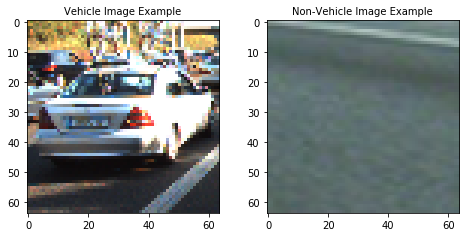

In [89]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example', fontsize=10)
ax2.imshow(non_vehicle_example)
ax2.set_title('Non-Vehicle Image Example', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipiline Definition

### Bin Spatial

In [90]:
# Resize images to 32x32 pixels
def bin_spatial(img, size=(32, 32), vis=False):
    
    if not vis:
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    else:
        img = cv2.resize(img, size)
        features = img.ravel() 
        #Return the feature vector and the image for visualization
        return features, img

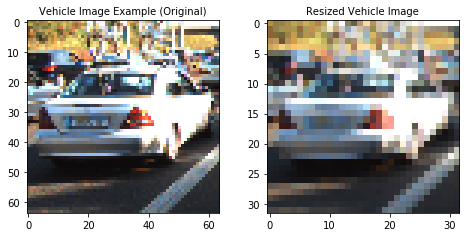

In [91]:
_, vehicle_example_bin = bin_spatial(vehicle_example, vis=True)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example (Original)', fontsize=10)
ax2.imshow(vehicle_example_bin)
ax2.set_title('Resized Vehicle Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Histogram 

In [120]:
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    if not vis:
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    else:
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

        hist_vis = np.array([channel1_hist[0], channel2_hist[0], channel3_hist[0]])
        
        return hist_features, hist_vis

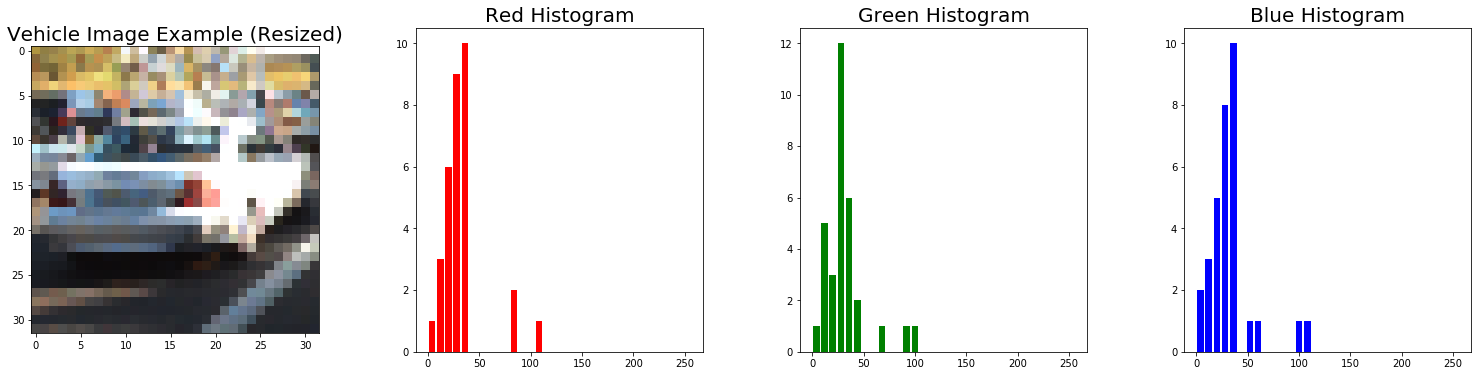

In [147]:
h, vehicle_example_hist = color_hist(vehicle_example_bin, vis=True)


# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 5))
f.tight_layout()
ax1.imshow(vehicle_example_bin)
ax1.set_title('Vehicle Image Example (Resized)', fontsize=20)
ax2.hist(vehicle_example_hist[0], bins = 32, range = (0, 256),  rwidth = 0.8, color='r')
ax2.set_title('Red Histogram', fontsize=20)
ax3.hist(vehicle_example_hist[1], bins = 32, range = (0, 256), rwidth = 0.8, color='g')
ax3.set_title('Green Histogram', fontsize=20)
ax4.hist(vehicle_example_hist[2], bins = 32, range = (0, 256), rwidth = 0.8, color='b')
ax4.set_title('Blue Histogram', fontsize=20)
plt.subplots_adjust(left=0., right=2, top=0.9, bottom=0.)

In [144]:
vehicle_example_bin

array([[[175, 148,  64],
        [144, 127,  68],
        [151, 129,  75],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[134, 103,  58],
        [143, 129,  78],
        [164, 145,  79],
        ...,
        [147, 135, 117],
        [109, 104,  95],
        [ 80,  91,  86]],

       [[144,  99,  54],
        [122, 107,  59],
        [115, 100,  55],
        ...,
        [175, 159,  98],
        [155, 145,  96],
        [ 68,  78,  82]],

       ...,

       [[ 84,  73,  68],
        [ 69,  59,  57],
        [ 52,  49,  52],
        ...,
        [ 40,  42,  45],
        [ 41,  41,  43],
        [ 37,  41,  45]],

       [[ 37,  41,  47],
        [ 37,  40,  49],
        [ 37,  40,  47],
        ...,
        [ 38,  40,  46],
        [ 38,  40,  41],
        [ 35,  39,  44]],

       [[ 71,  70,  69],
        [ 72,  67,  68],
        [ 88,  76,  69],
        ...,
        [ 35,  36,  42],
        [ 35,  36,  43],
        [ 34,  37,  47]]